# Exploring data for the attention index

The idea of the attention index is to provide a score that indicates the impact of an article, and can easily be aggregated by subject, publisher or other axis.

The index comprises of two parts:

- **promotion** how important the article was to the publisher, based on the extent to which they chose to editorially promote it
- **response** how readers reacted to the article, based on social engagements

The index will be a number between 0 and 100. 50% is driven by the promotion, and 50% by response:

![Attention Index](../images/kaleida-attention-index-data-factors-chart.png)

### Promotion Score

The promotion score should take into account:

- whether the publisher chose make the article a lead article on their primary front (30%)
- how long the publisher chose to retain the article on their front (40%)
- whether they chose to push the article on their facebook brand page (30%)

It should be scaled based on the value of that promotion, so a popular, well-visited site should score higher than one on the fringes. And similarly a powerful, well-followed brand page should score higher than one less followed.

### Response Score

The response score takes into account the number of engagements on Facebook. 



The rest of this notebook explores how those numbers could work, starting with the response score because that is easier, I think.

# Setup

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv("articles_2017-05-01_2017-05-31.csv", index_col="id", \
                   parse_dates=["published", "discovered"])
data.head()

,url,headline,discovered,published,fb_engagements,fb_max_engagements_per_min,fb_comments,fb_reactions,fb_shares,publisher_name,publisher_id,mins_as_lead,mins_on_front,num_articles_on_front,fb_brand_page,fb_brand_page_likes,alexa_rank
id,,,,,,,,,,,,,,,,,
0d2c10289ac562afa42b458bf238defd5b7d86d8,https://www.nytimes.com/2017/04/30/nyregion/me...,April Fools’ With the Epitome of Cool,2017-05-01 00:05:00.022,2017-05-01 00:00:00,5,0.083449,NaN,NaN,NaN,New York Times,nytimes_com,0,0,NaN,False,NaN,120
0d35eb2f3c53ad8218866a0927082b0a2a53576d,http://www.dailymail.co.uk/news/article-446135...,Young mother loses three teeth and is left nee...,2017-05-01 00:05:23.416,2017-05-01 00:00:21,8,0.083449,NaN,NaN,NaN,Daily Mail,dailymail_co_uk,0,584,603.0,False,NaN,158
20a659b9ee677b718b5834566795b6e231541a9b,http://www.dailymail.co.uk/tvshowbiz/article-4...,Holly Hagan slams 'jealous' trolls in angry Tw...,2017-05-01 00:05:19.176,2017-05-01 00:00:32,1,0.000000,NaN,NaN,NaN,Daily Mail,dailymail_co_uk,0,2352,603.0,False,NaN,158
7572bc3039f8f0ad83fea23d2692d5bd8a4cadd9,http://www.dailymail.co.uk/news/article-446135...,Primary school headteachers could strike over ...,2017-05-01 00:05:19.083,2017-05-01 00:00:32,10,0.083449,NaN,NaN,NaN,Daily Mail,dailymail_co_uk,0,1012,603.0,False,NaN,158
a8e2c63260f908b2f091862fff1b884da0eb5fe9,http://www.dailymail.co.uk/news/article-446138...,Man films student driver who 'fled from hit an...,2017-05-01 00:05:22.695,2017-05-01 00:00:48,12,0.083449,NaN,NaN,NaN,Daily Mail,dailymail_co_uk,0,0,NaN,False,NaN,158


# Response Score

The response score is a number between 0 and 50 that indicates the level of response to an article.



Perhaps in the future we may choose to include other factors, but for now we just include engagements on Facebook. The maximum score of 50 should be achieved by an article that does really well compared with others.

In [3]:
pd.options.display.float_format = '{:.2f}'.format
data.fb_engagements.describe([0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999])

count    128531.00
mean       1219.29
std        6211.63
min           0.00
50%          36.00
75%         362.00
90%        2256.00
95%        5690.00
99%       22447.10
99.5%     33332.15
99.9%     65258.53
max     1114468.00
Name: fb_engagements, dtype: float64

There's one article there with 1 million plus engagements, let's just double check that.

In [4]:
data[data.fb_engagements > 1000000]

,url,headline,discovered,published,fb_engagements,fb_max_engagements_per_min,fb_comments,fb_reactions,fb_shares,publisher_name,publisher_id,mins_as_lead,mins_on_front,num_articles_on_front,fb_brand_page,fb_brand_page_likes,alexa_rank
id,,,,,,,,,,,,,,,,,
c55509930e92f71ee534edf7d570b70ed81a2267,https://www.indy100.com/article/divorced-fathe...,This dad's brilliant post about his ex-wife is...,2017-05-15 11:09:18.339,2017-05-14 08:36:41,1114468,8.34,58501.00,914126.00,141841.00,indy100,indy100_com,0,9937,100.00,False,nan,5014


Yup. Facebook open graph debugger agrees with that, although it looks to me like facebook has got confused. But Kaleida is reflecting correctly what facebook is saying.

In [5]:
data.fb_engagements.mode()

0    0
dtype: int64

Going back to the enagement counts, we see the mean is 1,129, mode is zero, median is 36, 90th percentile is 2,256, 99th percentile is 22,447, 99.5th percentile is 33,332. The standard deviation is 6,211, significantly higher than the mean, so this is not a normal distribution. 

We want to provide a sensible way of allocating this to the 50 buckets we have available. Let's just bucket geometrically first:

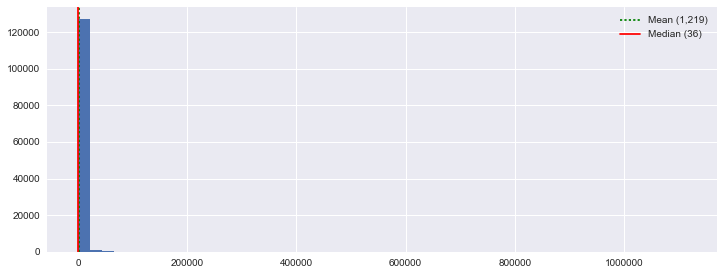

In [6]:
mean = data.fb_engagements.mean()
median = data.fb_engagements.median()

plt.figure(figsize=(12,4.5))
plt.hist(data.fb_engagements, bins=50)
plt.axvline(mean, linestyle=':', label=f'Mean ({mean:,.0f})', color='green')
plt.axvline(median, label=f'Median ({median:,.0f})', color='red')
leg = plt.legend()


Well that's not very useful. Almost everything will score less than 0 if we just do that, which isn't a useful metric.

Let's start by excluding zeros.

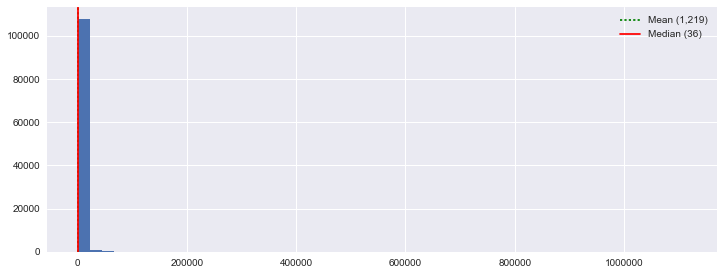

In [7]:
non_zero_fb_enagagements = data.fb_engagements[data.fb_engagements > 0]

plt.figure(figsize=(12,4.5))
plt.hist(non_zero_fb_enagagements, bins=50)
plt.axvline(mean, linestyle=':', label=f'Mean ({mean:,.0f})', color='green')
plt.axvline(median, label=f'Median ({median:,.0f})', color='red')
leg = plt.legend()

That's still a big number at the bottom, and so not a useful score.

Next, we exclude the outliers: cap at the 99.9th percentile (i.e. 65,258.53), so that 0.1% of articles should receive the maximum score.


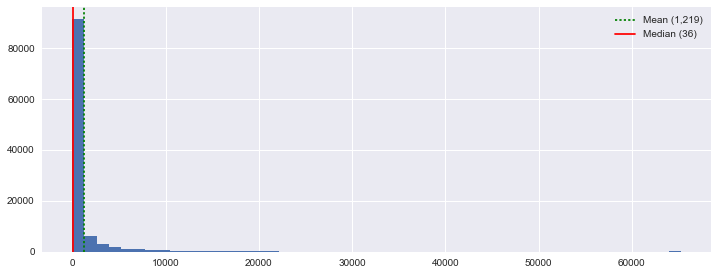

In [8]:
non_zero_fb_enagagements_without_outliers = non_zero_fb_enagagements.clip_upper(65258.53)

plt.figure(figsize=(12,4.5))
plt.hist(non_zero_fb_enagagements_without_outliers, bins=50)
plt.axvline(mean, linestyle=':', label=f'Mean ({mean:,.0f})', color='green')
plt.axvline(median, label=f'Median ({median:,.0f})', color='red')
leg = plt.legend()

That's a bit better, but still way too clustered at the low end. Let's look at a log normal distribution.

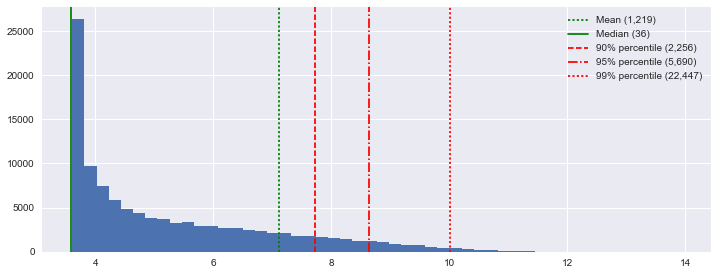

In [9]:
mean = data.fb_engagements.mean()
median = data.fb_engagements.median()
ninety = data.fb_engagements.quantile(.90)
ninetyfive = data.fb_engagements.quantile(.95)
ninetynine = data.fb_engagements.quantile(.99)

plt.figure(figsize=(12,4.5))
plt.hist(np.log(non_zero_fb_enagagements + median), bins=50)
plt.axvline(np.log(mean), linestyle=':', label=f'Mean ({mean:,.0f})', color='green')
plt.axvline(np.log(median), label=f'Median ({median:,.0f})', color='green')
plt.axvline(np.log(ninety), linestyle='--', label=f'90% percentile ({ninety:,.0f})', color='red')
plt.axvline(np.log(ninetyfive), linestyle='-.', label=f'95% percentile ({ninetyfive:,.0f})', color='red')
plt.axvline(np.log(ninetynine), linestyle=':', label=f'99% percentile ({ninetynine:,.0f})', color='red')
leg = plt.legend()


That's looking a bit more interesting.

After some exploration, to avoid too much emphasis on the lower end of the scale, we move the numbers to the right a bit by adding on the median.

In [10]:
log_engagements = (non_zero_fb_enagagements
                   .clip_upper(data.fb_engagements.quantile(.999))
                   .apply(lambda x: np.log(x + median))
                  )
log_engagements.describe()

count   109192.00
mean         5.29
std          1.73
min          3.61
25%          3.83
50%          4.66
75%          6.35
max         11.09
Name: fb_engagements, dtype: float64

Use standard feature scaling to bring that to a 1 to 50 range


In [11]:
def scale_log_engagements(engagements_logged):
    return np.ceil(
        49 * (engagements_logged - log_engagements.min()) / (log_engagements.max() - log_engagements.min())
    ) + 1

def scale_engagements(engagements):
    return scale_log_engagements(np.log(engagements + median))

scaled_non_zero_engagements = scale_log_engagements(log_engagements)
scaled_non_zero_engagements.describe()

count   109192.00
mean        12.46
std         11.35
min          1.00
25%          3.00
50%          8.00
75%         19.00
max         50.00
Name: fb_engagements, dtype: float64

In [12]:
# add in the zeros, as zero
scaled_engagements = pd.concat([scaled_non_zero_engagements, data.fb_engagements[data.fb_engagements == 0]])

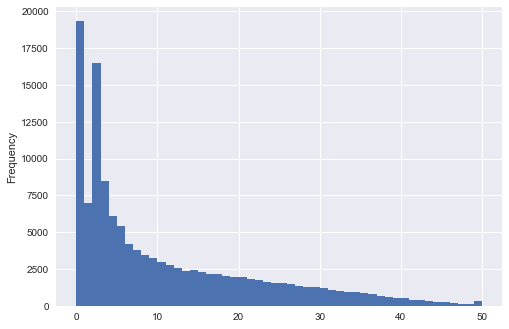

In [13]:
proposed = pd.DataFrame({"fb_engagements": data.fb_engagements, "response_score": scaled_engagements})
proposed.response_score.plot.hist(bins=50)

Now look at how the shares distribute to score:

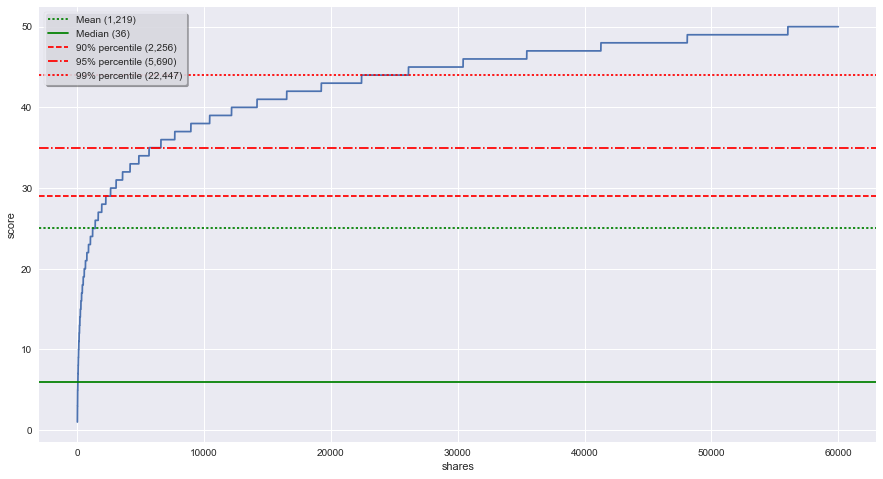

In [14]:
plt.figure(figsize=(15,8))

shares = np.arange(1, 60000)
plt.plot(shares, scale_engagements(shares))
plt.xlabel("shares")
plt.ylabel("score")
plt.axhline(scale_engagements(mean), linestyle=':', label=f'Mean ({mean:,.0f})', color='green')
plt.axhline(scale_engagements(median), label=f'Median ({median:,.0f})', color='green')
plt.axhline(scale_engagements(ninety), linestyle='--', label=f'90% percentile ({ninety:,.0f})', color='red')
plt.axhline(scale_engagements(ninetyfive), linestyle='-.', label=f'95% percentile ({ninetyfive:,.0f})', color='red')
plt.axhline(scale_engagements(ninetynine), linestyle=':', label=f'99% percentile ({ninetynine:,.0f})', color='red')

plt.legend(frameon=True, shadow=True)



In [15]:
proposed.groupby("response_score").fb_engagements.agg([np.size, np.min, np.max])

,size,amin,amax
response_score,,,
0.00,19339,0,0
1.00,6976,1,1
2.00,16495,2,7
3.00,8507,8,14
4.00,6122,15,22
5.00,5409,23,32
6.00,4219,33,43
7.00,3782,44,56
8.00,3455,57,71


Looks good to me, lets save that.

In [16]:
data["response_score"] = proposed.response_score

### Proposal

The maximum of 50 points is awarded when the engagements are greater than the 99.9th percentile, rolling over the last month. 

i.e. where $limit$ is the 99.5th percentile of engagements calculated over the previous month, the response score for article $a$ is:

\begin{align}
basicScore_a & = 
\begin{cases} 
   0 & \text{if } engagements_a = 0 \\
   \log(\min(engagements_a,limit) + median(engagements))      & \text{if } engagements_a > 0
\end{cases} \\
responseScore_a & = 
\begin{cases} 
   0 & \text{if } engagements_a = 0 \\
   49 \cdot \frac{basicScore_a - \min(basicScore)}{\max(basicScore) - \min(basicScore)} + 1      & \text{if } engagements_a > 0
\end{cases} \\
\\
\text{The latter equation can be expanded to:} \\
responseScore_a & = 
\begin{cases} 
   0 & \text{if } engagements_a = 0 \\
   49 \cdot 
   \frac{\log(\min(engagements_a,limit) + median(engagements)) - \log(1 + median(engagements))}
   {\log(limit + median(engagements)) - \log(1 + median(engagements))} + 1      & \text{if } engagements_a > 0
\end{cases} \\
\end{align}

# Promotion Score

The aim of the promotion score is to indicate how important the article was to the publisher, by tracking where they chose to promote it. This is a number between 0 and 50 comprised of:

- 20 points based on whether the article was promoted as the "lead" story on the publisher's home page
- 15 points based on how long the article was promoted anywhere on the publisher's home page
- 15 points based on whether the article was promoted on the publisher's main facebook brand page

The first two should be scaled by the popularity/reach of the home page, for which we use the alexa page rank as a proxy.

The last should be scaled by the popularity/reach of the brand page, for which we use the number of likes the brand page has.

### Lead story (20 points)

In [17]:
(data.mins_as_lead / 60).describe([0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999])

count   128531.00
mean         0.14
std          1.59
min          0.00
50%          0.00
75%          0.00
90%          0.00
95%          0.00
99%          4.18
99.5%        8.68
99.9%       19.06
max        243.07
Name: mins_as_lead, dtype: float64

I don't think there's any point in giving credit for things on the front for over 24 hours (1,440 minutes). We also want to scale this by the alexa page rank, such that the maximum score of 20 points is for an article that was on the front for 24 hours for the most popular site.

So lets explore the alexa nunbers.

In [18]:
alexa_ranks = data.groupby(by="publisher_id").alexa_rank.mean().sort_values()
alexa_ranks

publisher_id
bbc_co_uk                               96
cnn_com                                105
nytimes_com                            120
theguardian_com                        142
buzzfeed_com                           147
dailymail_co_uk                        158
washingtonpost_com                     191
huffingtonpost_com                     215
foxnews_com                            285
rt_com                                 365
telegraph_co_uk                        370
independent_co_uk                      386
reuters_com                            497
npr_org                                594
nbcnews_com                            826
breitbart_com                          994
ft_com                                1596
economist_com                         1825
indy100_com                           5014
thetimes_co_uk                        6435
thecanary_co                         15686
propublica_org                       16066
yournewswire_com                     2256

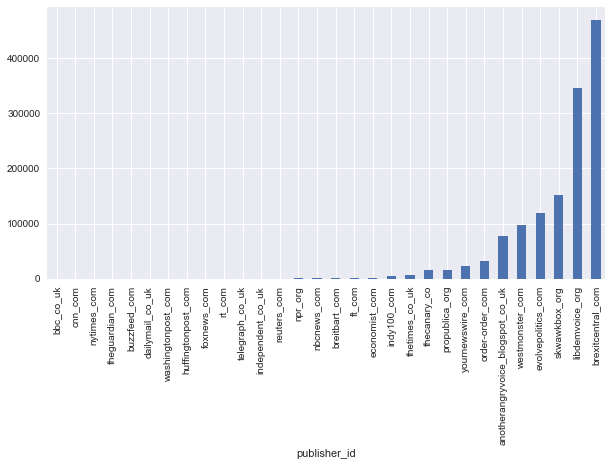

In [19]:
alexa_ranks.plot.bar(figsize=[10,5])

Let's try the simple option first: just divide the number of minutes as lead by the alexa rank. What's the scale of numbers we get then.

In [20]:
lead_articles = data[data.mins_as_lead > 0]

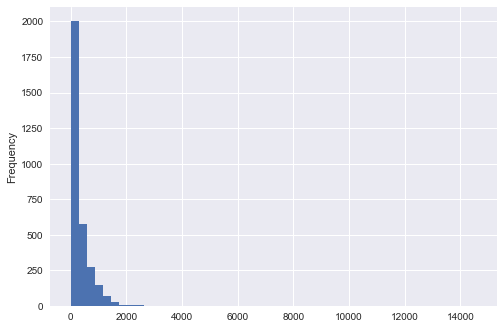

In [21]:
lead_articles.mins_as_lead.plot.hist(bins=50)

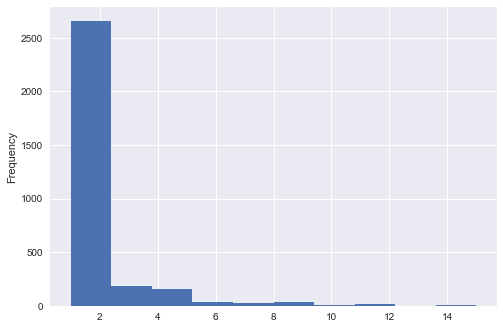

In [22]:
lead_proposal_1 = np.ceil(lead_articles.mins_as_lead.clip_upper(1440) / lead_articles.alexa_rank)
lead_proposal_1.plot.hist()

Accidentally, that's in the kind of range we want, but have we massively over penalised the publishers with a high alexa rank?

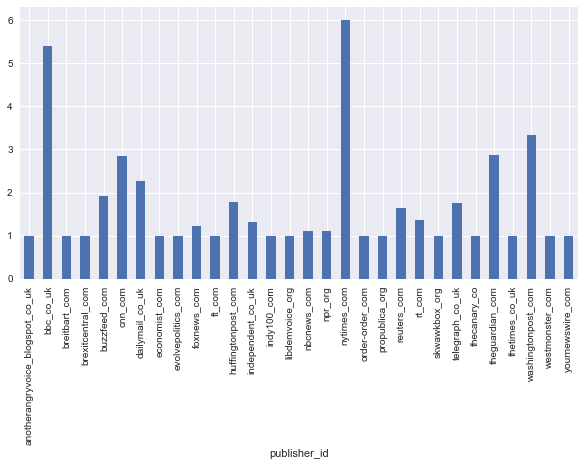

In [23]:
lead_proposal_1.groupby(data.publisher_id).mean().plot.bar(figsize=[10,5])

Let's try taking the log of the alexa rank and see if that looks better.

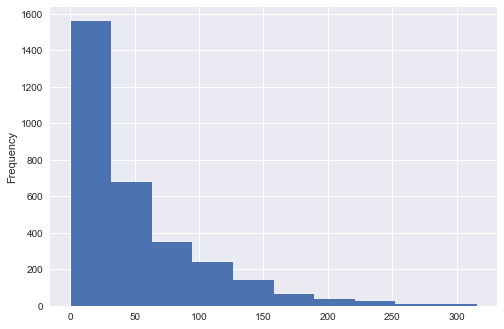

In [24]:
lead_proposal_2 = (lead_articles.mins_as_lead.clip_upper(1440) / np.log(lead_articles.alexa_rank))
lead_proposal_2.plot.hist()

In [25]:
lead_proposal_2.groupby(data.publisher_id).describe()

,count,mean,std,min,25%,50%,75%,max
publisher_id,,,,,,,,
anotherangryvoice_blogspot_co_uk,33.00,51.27,45.28,2.57,13.76,36.76,83.82,127.86
bbc_co_uk,96.00,102.59,70.66,0.88,51.27,85.12,145.69,315.49
breitbart_com,206.00,31.97,22.85,2.03,19.56,25.50,32.53,141.99
brexitcentral_com,27.00,61.15,40.15,1.45,16.23,67.01,101.04,110.27
buzzfeed_com,105.00,43.73,48.25,1.80,22.84,28.05,45.89,288.55
cnn_com,181.00,52.91,42.04,4.08,24.71,39.54,70.91,309.41
dailymail_co_uk,159.00,55.57,47.78,3.75,23.90,37.33,69.73,262.51
economist_com,44.00,93.21,65.97,0.67,38.98,84.89,157.20,191.76
evolvepolitics_com,26.00,57.41,47.08,2.14,11.03,37.85,103.23,123.18


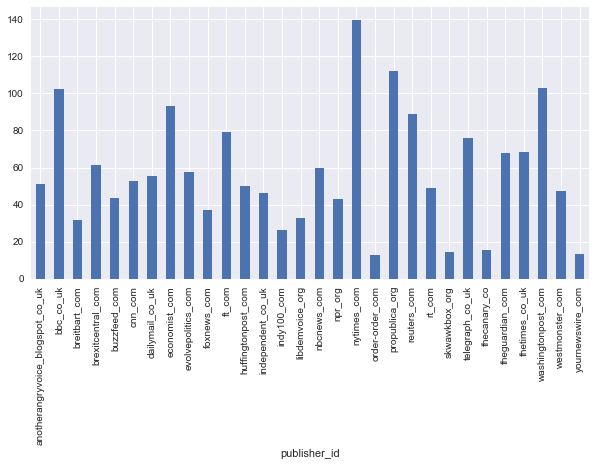

In [26]:
lead_proposal_2.groupby(data.publisher_id).mean().plot.bar(figsize=[10,5])

Nope. That's giving way too much credit to the smaller publishers.

Now we need to adjust the range of this so that it's a number from 0 to 20. The maximum possible value is $\frac{1440}{\min(alexaRank)}$:

In [27]:
1440 / alexa_ranks.min()

15.0

So to get a score between 0 and 20 we need to divide by 15 and multiply by 20:

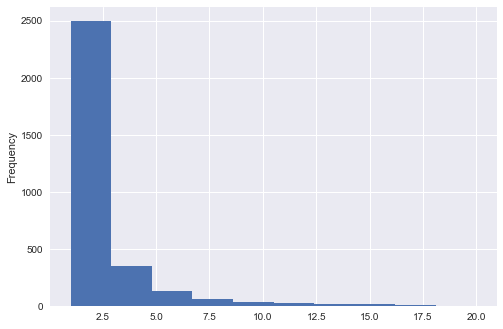

In [28]:
lead_proposal_3 = np.ceil(lead_articles.mins_as_lead.clip_upper(1440) / lead_articles.alexa_rank / 15 * 20)
lead_proposal_3.plot.hist()

In [29]:
data["lead_score"] = np.ceil(data.mins_as_lead.clip_upper(1440) / data.alexa_rank / 15 * 20)

In [30]:
data.lead_score.value_counts().sort_index()

0.00     125410
1.00       1996
2.00        500
3.00        214
4.00        132
5.00         64
6.00         66
7.00         38
8.00         22
9.00         20
10.00        11
11.00        15
12.00        12
13.00         6
14.00         7
15.00         4
16.00         8
17.00         1
18.00         3
19.00         1
20.00         1
Name: lead_score, dtype: int64

In summary then, score for article $a$ is:

$$leadScore_a = 20 \left(\frac{\min(minsAsLead_a, 1440)}{alexaRank_a}\right) \left( \frac{\min(alexaRank)}{1440} \right)$$

## Time on front score (15 points)

This is similar to time as lead, so lets try doing the same calculation, except we also want to factor in the number of slots on the front:


$$frontScore_a = 
15 
\left(\frac{\min(minsOnFront_a, 1440)}{alexaRank_a \cdot numArticlesOnFront_a}\right) 
\left( \frac{\min(alexaRank \cdot numArticlesOnFront)}{1440} \right)$$

In [31]:
(data.alexa_rank * data.num_articles_on_front).min() / 1440

2.4500000000000002

In [32]:
time_on_front_proposal_1 = np.ceil(data.mins_on_front.clip_upper(1440) / (data.alexa_rank * data.num_articles_on_front) * (2.45) * 15)

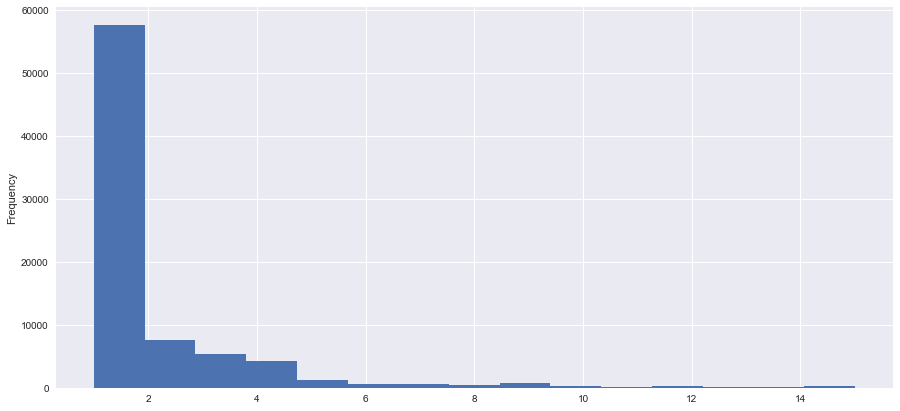

In [33]:
time_on_front_proposal_1.plot.hist(figsize=(15, 7), bins=15)

In [34]:
time_on_front_proposal_1.value_counts().sort_index()

1.00     57630
2.00      7582
3.00      5342
4.00      4237
5.00      1161
6.00       680
7.00       578
8.00       498
9.00       731
10.00      271
11.00      123
12.00      321
13.00       66
14.00       49
15.00      317
dtype: int64

In [35]:
time_on_front_proposal_1.groupby(data.publisher_id).sum()

publisher_id
anotherangryvoice_blogspot_co_uk      60.00
bbc_co_uk                          14530.00
breitbart_com                       2592.00
brexitcentral_com                     40.00
buzzfeed_com                       11209.00
cnn_com                            12716.00
dailymail_co_uk                    14314.00
economist_com                        328.00
evolvepolitics_com                    47.00
foxnews_com                         9078.00
ft_com                              3300.00
huffingtonpost_com                  8148.00
independent_co_uk                   4942.00
indy100_com                          415.00
libdemvoice_org                      104.00
nbcnews_com                         2022.00
npr_org                             2733.00
nytimes_com                         9710.00
order-order_com                      226.00
propublica_org                        40.00
reuters_com                         7027.00
rt_com                              2200.00
skwawkbox_org      

That looks good to me.

In [36]:
data["front_score"] = np.ceil(data.mins_on_front.clip_upper(1440) / (data.alexa_rank * data.num_articles_on_front) * (2.45) * 15).fillna(0)

In [37]:
data.front_score 

id
0d2c10289ac562afa42b458bf238defd5b7d86d8    0.00
0d35eb2f3c53ad8218866a0927082b0a2a53576d    1.00
20a659b9ee677b718b5834566795b6e231541a9b    1.00
7572bc3039f8f0ad83fea23d2692d5bd8a4cadd9    1.00
a8e2c63260f908b2f091862fff1b884da0eb5fe9    0.00
73a0112050c4cc9ed84283e554320c252503624c    1.00
9599a718d0004a66b97fbf3679e7fc3efc2172ef    0.00
1d3c90bfd083053501ee225c3a744d8b29cd51a8    1.00
a5235e1a73a409d927fd3d2ee1b82f9684b131c9    1.00
fc2a46c86e4f57b3e6f6ec9f3cb67a0f4bf1687f    3.00
71677691696f159fe2c72c8a518d786ac058c29c    1.00
165bc8d9292928cd1c95517f368e6e01912fa93c    8.00
c07415e598aa79d92d02cf453da42b04ed6346af    0.00
9ac7ebf2b4ea4db4b588dd917c36020ab66a5c94   12.00
aa3d9df1b0ed9dd9a6af0e7c320961b955694313    0.00
a6e840df7019548c0f027b3bb25b76d232fda5c0    0.00
49b056d35946eac75f3487f48bd9d98d2f01cf6d    8.00
92582d085e7a346254e10df2dc5e1a107fd41429    1.00
3ba688954a3a02b733b9008ea53ba53d09bac620    1.00
290c5016d53b641a16b46442acc17c82c096e2f7    1.00
77f30ff0be3bc69e5

## Facebook brand page promotion (15 points)

One way a publisher has of promoting content is to post to their brand page. The significance of doing so is stronger when the brand page has more followers (likes).

$$ facebookPromotionProposed1_a = 15 \left( \frac {brandPageLikes_a} {\max(brandPageLikes)} \right) $$

Now lets explore the data to see if that makes sense. **tr;dr the formula above is incorrect**

In [38]:
data.fb_brand_page_likes.max()

41834404.0

In [39]:
facebook_promotion_proposed_1 = np.ceil((15 * (data.fb_brand_page_likes / data.fb_brand_page_likes.max())).fillna(0))

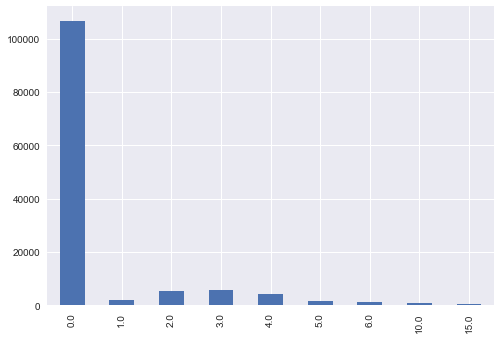

In [40]:
facebook_promotion_proposed_1.value_counts().sort_index().plot.bar()

In [41]:
facebook_promotion_proposed_1.groupby(data.publisher_id).describe()

,count,mean,std,min,25%,50%,75%,max
publisher_id,,,,,,,,
anotherangryvoice_blogspot_co_uk,60.00,0.45,0.50,0.00,0.00,0.00,1.00,1.00
bbc_co_uk,3682.00,2.16,5.27,0.00,0.00,0.00,0.00,15.00
breitbart_com,2722.00,0.62,0.93,0.00,0.00,0.00,2.00,2.00
brexitcentral_com,47.00,0.60,0.50,0.00,0.00,1.00,1.00,1.00
buzzfeed_com,1962.00,0.28,0.45,0.00,0.00,0.00,1.00,1.00
cnn_com,3923.00,2.45,4.30,0.00,0.00,0.00,0.00,10.00
dailymail_co_uk,25993.00,0.46,1.33,0.00,0.00,0.00,0.00,5.00
economist_com,576.00,2.02,1.41,0.00,0.00,3.00,3.00,3.00
evolvepolitics_com,54.00,0.72,0.45,0.00,0.00,1.00,1.00,1.00


That's too much variation: sites like the Guardian, which have a respectable 7.5m likes, should not be scoring a 3. Lets try applying a log to it, and then standard feature scaling again.

In [42]:
data.fb_brand_page_likes.groupby(data.publisher_id).max()

publisher_id
anotherangryvoice_blogspot_co_uk     300227.00
bbc_co_uk                          41834404.00
breitbart_com                       3422611.00
brexitcentral_com                      6484.00
buzzfeed_com                        2526061.00
cnn_com                            27506850.00
dailymail_co_uk                    11298065.00
economist_com                       8088734.00
evolvepolitics_com                    79072.00
foxnews_com                        15383159.00
ft_com                              3547359.00
huffingtonpost_com                  9494261.00
independent_co_uk                   6908633.00
indy100_com                          183154.00
libdemvoice_org                        8169.00
nbcnews_com                         8979704.00
npr_org                             6008762.00
nytimes_com                        14025241.00
order-order_com                       41270.00
propublica_org                       331091.00
reuters_com                         3733774.00


In [43]:
np.log(2149)

7.6727578966425103

In [44]:
np.log(data.fb_brand_page_likes.groupby(data.publisher_id).max())

publisher_id
anotherangryvoice_blogspot_co_uk   12.61
bbc_co_uk                          17.55
breitbart_com                      15.05
brexitcentral_com                   8.78
buzzfeed_com                       14.74
cnn_com                            17.13
dailymail_co_uk                    16.24
economist_com                      15.91
evolvepolitics_com                 11.28
foxnews_com                        16.55
ft_com                             15.08
huffingtonpost_com                 16.07
independent_co_uk                  15.75
indy100_com                        12.12
libdemvoice_org                     9.01
nbcnews_com                        16.01
npr_org                            15.61
nytimes_com                        16.46
order-order_com                    10.63
propublica_org                     12.71
reuters_com                        15.13
rt_com                             15.31
skwawkbox_org                       7.67
telegraph_co_uk                    15.24
the

That's more like it, but the lower numbers should be smaller.

In [45]:
np.log(data.fb_brand_page_likes.groupby(data.publisher_id).max() / 1000)

publisher_id
anotherangryvoice_blogspot_co_uk    5.70
bbc_co_uk                          10.64
breitbart_com                       8.14
brexitcentral_com                   1.87
buzzfeed_com                        7.83
cnn_com                            10.22
dailymail_co_uk                     9.33
economist_com                       9.00
evolvepolitics_com                  4.37
foxnews_com                         9.64
ft_com                              8.17
huffingtonpost_com                  9.16
independent_co_uk                   8.84
indy100_com                         5.21
libdemvoice_org                     2.10
nbcnews_com                         9.10
npr_org                             8.70
nytimes_com                         9.55
order-order_com                     3.72
propublica_org                      5.80
reuters_com                         8.23
rt_com                              8.40
skwawkbox_org                       0.77
telegraph_co_uk                     8.33
the

In [46]:
scaled_fb_brand_page_likes = (data.fb_brand_page_likes / 1000)
facebook_promotion_proposed_2 = np.ceil(\
    (15 * \
     (np.log(scaled_fb_brand_page_likes) / np.log(scaled_fb_brand_page_likes.max()))\
    )\
                                       ).fillna(0)

In [47]:
facebook_promotion_proposed_2.groupby(data.publisher_id).max()

publisher_id
anotherangryvoice_blogspot_co_uk    9.00
bbc_co_uk                          15.00
breitbart_com                      12.00
brexitcentral_com                   3.00
buzzfeed_com                       12.00
cnn_com                            15.00
dailymail_co_uk                    14.00
economist_com                      13.00
evolvepolitics_com                  7.00
foxnews_com                        14.00
ft_com                             12.00
huffingtonpost_com                 13.00
independent_co_uk                  13.00
indy100_com                         8.00
libdemvoice_org                     3.00
nbcnews_com                        13.00
npr_org                            13.00
nytimes_com                        14.00
order-order_com                     6.00
propublica_org                      9.00
reuters_com                        12.00
rt_com                             12.00
skwawkbox_org                       2.00
telegraph_co_uk                    12.00
the

LGTM. So the equation is


$$ facebookPromotion_a = 15 \left( 
\frac {\log(\frac {brandPageLikes_a}{1000})} 
{\log(\frac {\max(brandPageLikes)}{1000}))} \right) $$


Now, let's try applying standard feature scaling approch to this, rather than using a magic number of 1,000. That equation would be:

\begin{align}
unscaledFacebookPromotion_a &= 
   \log(brandPageLikes_a) \\
facebookPromotion_a &= 
   14 \cdot \frac{unscaledFacebookPromotion_a - \min(unscaledFacebookPromotion)}{\max(unscaledFacebookPromotion) - \min(unscaledFacebookPromotion)} + 1 \\
\\
\text{The scaling can be simplified to:} \\
facebookPromotion_a &= 
   14 \cdot \frac{unscaledFacebookPromotion_a - \log(\min(brandPageLikes))}{\log(\max(brandPageLikes)) - \log(\min(brandPageLikes))} + 1 \\
\\
\text{Meaning the overall equation becomes:} \\
facebookPromotion_a &= 
   14 \cdot \frac{\log(brandPageLikes_a) - \log(\min(brandPageLikes))}{\log(\max(brandPageLikes)) - \log(\min(brandPageLikes))} + 1  
   \end{align}


In [48]:
facebook_promotion_proposed_3 = np.ceil(
    (14 * 
     ( 
         (np.log(data.fb_brand_page_likes) - np.log(data.fb_brand_page_likes.min()) ) /
         (np.log(data.fb_brand_page_likes.max()) - np.log(data.fb_brand_page_likes.min()))
     )
    ) + 1
                                       )

In [49]:
facebook_promotion_proposed_3.groupby(data.publisher_id).max()

publisher_id
anotherangryvoice_blogspot_co_uk    9.00
bbc_co_uk                          15.00
breitbart_com                      12.00
brexitcentral_com                   3.00
buzzfeed_com                       12.00
cnn_com                            15.00
dailymail_co_uk                    14.00
economist_com                      13.00
evolvepolitics_com                  7.00
foxnews_com                        14.00
ft_com                             12.00
huffingtonpost_com                 13.00
independent_co_uk                  13.00
indy100_com                         8.00
libdemvoice_org                     4.00
nbcnews_com                        13.00
npr_org                            13.00
nytimes_com                        14.00
order-order_com                     6.00
propublica_org                      9.00
reuters_com                        12.00
rt_com                             12.00
skwawkbox_org                       2.00
telegraph_co_uk                    12.00
the

In [50]:
data["facebook_promotion_score"] = facebook_promotion_proposed_3.fillna(0.0)

# Review

In [51]:
data["promotion_score"] = (data.lead_score + data.front_score + data.facebook_promotion_score)
data["attention_index"] = (data.promotion_score + data.response_score)

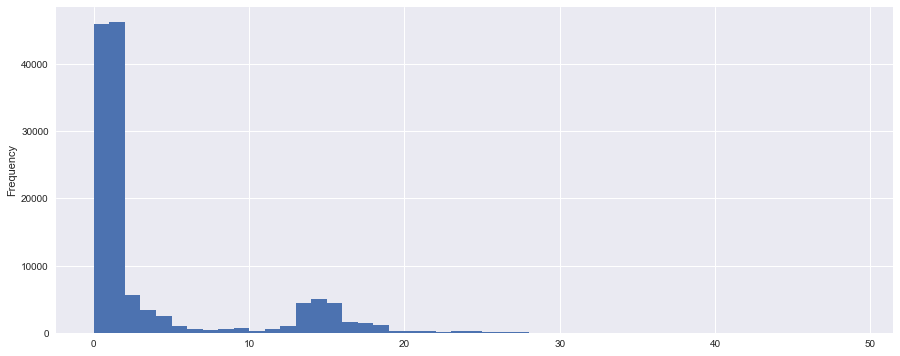

In [52]:
data.promotion_score.plot.hist(bins=np.arange(50), figsize=(15,6))

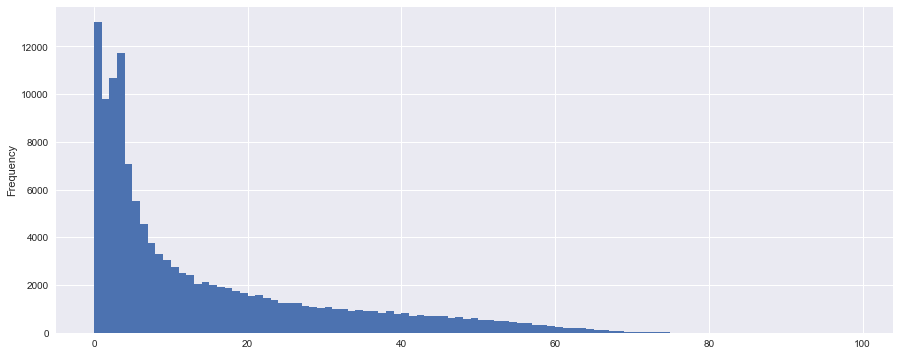

In [53]:
data.attention_index.plot.hist(bins=np.arange(100), figsize=(15,6))

In [54]:
data.attention_index.value_counts().sort_index()

0.00     13019
1.00      9790
2.00     10695
3.00     11735
4.00      7095
5.00      5530
6.00      4568
7.00      3781
8.00      3321
9.00      3065
10.00     2762
11.00     2498
12.00     2408
13.00     2060
14.00     2115
15.00     2009
16.00     1904
17.00     1873
18.00     1743
19.00     1687
20.00     1551
21.00     1570
22.00     1449
23.00     1383
24.00     1229
25.00     1241
26.00     1241
27.00     1141
28.00     1070
29.00     1045
         ...  
56.00      396
57.00      330
58.00      312
59.00      282
60.00      255
61.00      209
62.00      192
63.00      181
64.00      153
65.00      134
66.00       97
67.00       85
68.00       60
69.00       46
70.00       39
71.00       29
72.00       21
73.00       25
74.00       14
75.00       10
76.00       10
77.00        4
78.00        4
79.00        2
80.00        6
81.00        3
82.00        3
83.00        2
84.00        4
88.00        2
Name: attention_index, Length: 86, dtype: int64

In [55]:
# and lets see the most promoted articles
data.sort_values("attention_index", ascending=False)

,url,headline,discovered,published,fb_engagements,fb_max_engagements_per_min,fb_comments,fb_reactions,fb_shares,publisher_name,...,num_articles_on_front,fb_brand_page,fb_brand_page_likes,alexa_rank,response_score,lead_score,front_score,facebook_promotion_score,promotion_score,attention_index
id,,,,,,,,,,,,,,,,,,,,,
a6512f6b09240bd0ad24afe567bc301979abceca,http://www.bbc.co.uk/news/election-2017-39956541,Conservative manifesto: Firms to pay more to h...,2017-05-17 21:15:08.119,2017-05-17 21:14:28,15755,14.98,6394.00,7365.00,1996.00,BBC,...,47.00,True,41465378.00,96,41.00,20.00,12.00,15.00,47.00,88.00
332d434b07b350510549833225fe392117243c0c,http://www.cnn.com/2017/05/04/politics/health-...,Countdown is on to nail-biter Obamacare repeal...,2017-05-04 10:05:24.746,2017-05-04 10:00:18,27425,39.17,nan,nan,nan,CNN,...,62.00,True,27396532.00,105,45.00,19.00,9.00,15.00,43.00,88.00
f8830bbc4e15dab7593e0751b9851c048c575257,https://www.nytimes.com/2017/05/16/us/politics...,Comey Memo Says Trump Asked Him to End Flynn I...,2017-05-16 21:24:00.845,2017-05-16 21:22:12,83951,49.67,30914.00,46208.00,6829.00,New York Times,...,121.00,True,13926019.00,120,50.00,16.00,4.00,14.00,34.00,84.00
504fc46f0894ca4d241c2ae6a231c8151fdaaec5,http://www.bbc.co.uk/news/uk-40023488,UK threat level raised to highest level,2017-05-23 20:55:01.049,2017-05-23 20:45:23,26136,23.17,5633.00,15422.00,5081.00,BBC,...,47.00,True,41636128.00,96,45.00,15.00,9.00,15.00,39.00,84.00
3c3f7fb5403ff83481e2ddef31808250086ea752,http://www.bbc.co.uk/news/uk-politics-39877439,General election 2017: Labour pledges in 'mani...,2017-05-10 20:56:01.055,2017-05-10 20:52:19,15222,27.12,nan,nan,nan,BBC,...,47.00,True,41345683.00,96,41.00,16.00,12.00,15.00,43.00,84.00
bdd744b41f998a5cac12ae15ab5f1d08ff437019,http://www.bbc.co.uk/news/world-us-canada-3998...,Trump in Saudi Arabia: Key deals expected to b...,2017-05-20 08:50:01.940,2017-05-20 08:40:56,17435,31.68,3105.00,12673.00,1657.00,BBC,...,47.00,True,41521632.00,96,42.00,17.00,10.00,15.00,42.00,84.00
7cb9f49a9bd8be5a0c54a8fac7c5c829eaaa3255,https://www.nytimes.com/2017/05/19/us/politics...,Trump Told Russians That Firing ‘Nut Job’ Come...,2017-05-19 18:57:03.616,2017-05-19 18:54:34,69396,54.49,18795.00,43237.00,7364.00,New York Times,...,121.00,True,13944205.00,120,50.00,15.00,4.00,14.00,33.00,83.00
f1ba80ccf9b7979418c5326503bc897b98eafd92,http://www.bbc.co.uk/news/world-europe-39839349,French election: Macron 'defeats Le Pen to bec...,2017-05-07 18:12:02.316,2017-05-07 18:07:12,64768,68.76,nan,nan,nan,BBC,...,47.00,True,41277414.00,96,50.00,11.00,7.00,15.00,33.00,83.00
09a3a8400c4395f2e18ba818b42912357e8e58ae,http://www.bbc.co.uk/news/election-2017-40053427,General election 2017: Corbyn links terror thr...,2017-05-25 21:10:03.897,2017-05-25 21:03:46,28189,34.00,11358.00,14371.00,2460.00,BBC,...,47.00,True,41702575.00,96,45.00,12.00,10.00,15.00,37.00,82.00


In [56]:
data["score_diff"] = data.promotion_score - data.response_score

In [57]:
# promoted but low response
data.sort_values("score_diff", ascending=False).head(25)

,url,headline,discovered,published,fb_engagements,fb_max_engagements_per_min,fb_comments,fb_reactions,fb_shares,publisher_name,...,fb_brand_page,fb_brand_page_likes,alexa_rank,response_score,lead_score,front_score,facebook_promotion_score,promotion_score,attention_index,score_diff
id,,,,,,,,,,,,,,,,,,,,,
276f94591dbcc1637e7b17ef8c1f756f55875256,https://www.buzzfeed.com/josephbernstein/the-p...,The Public Square Belongs to 4Chan,2017-05-18 19:45:20.292,2017-05-17 16:56:19.000,0,0.00,0.00,0.00,0.00,Buzzfeed News,...,True,2498318.00,147,0.00,7.00,15.00,12.00,34.00,34.00,34.00
2e86caccaa0f4d2487fbfe7e66c7d9a1bd7d9700,https://www.buzzfeed.com/jtes/california-non-b...,This 17-Year-Old Wanted A Name Change. They Ma...,2017-05-25 18:35:06.550,2017-05-24 21:17:42.000,1,0.02,0.00,0.00,1.00,Buzzfeed News,...,True,2522329.00,147,1.00,2.00,15.00,12.00,29.00,30.00,28.00
863bb66e6f8a3b24e80fa0041a29bdaad8daf393,https://www.buzzfeed.com/nourzibdeh/heres-what...,Here's What A Muslim Dietitian Eats During Ram...,2017-05-27 14:18:13.175,2017-05-25 20:13:24.000,2,0.17,0.00,0.00,2.00,Buzzfeed News,...,True,2522945.00,147,2.00,0.00,15.00,12.00,27.00,29.00,25.00
86e29ec1cdb2bfbaca4c7d5c7dced916b514bba8,https://www.buzzfeed.com/bimadewunmi/flint-isn...,Flint Isn’t Ready To Trust Anyone Yet,2017-05-24 22:15:04.778,2017-05-22 22:45:04.000,43,0.08,2.00,18.00,23.00,Buzzfeed News,...,True,2523526.00,147,6.00,3.00,15.00,12.00,30.00,36.00,24.00
b719c5a9926a584c03998c5cb3b966189d9f2355,https://www.buzzfeed.com/jimdalrympleii/the-fa...,An Epic Legal Battle Is Brewing As Trump Sizes...,2017-05-26 22:15:06.656,2017-05-25 23:53:39.000,35,0.27,4.00,7.00,24.00,Buzzfeed News,...,True,2521837.00,147,6.00,2.00,15.00,12.00,29.00,35.00,23.00
7816f63fd193beb025ee6580872c332ea26a7862,http://www.huffingtonpost.com/entry/politician...,Doing The Right Thing Shouldn’t Be This Remark...,2017-05-27 12:21:11.369,2017-05-26 11:42:33.000,1,0.08,0.00,0.00,1.00,HuffPost,...,True,9478219.00,215,1.00,0.00,10.00,13.00,23.00,24.00,22.00
2b43f24a9fa18f5f7cf1abb612d7a3b4c3a00fcb,http://www.huffingtonpost.com/entry/kumail-nan...,Kumail Nanjiani Tells Grads To ‘Have Sex With ...,2017-05-28 05:12:28.785,2017-05-26 16:22:22.000,3,0.17,0.00,0.00,3.00,HuffPost,...,True,9482374.00,215,2.00,0.00,10.00,13.00,23.00,25.00,21.00
8447720544b180b2e9fa38e8bdb3ab1b87861cfd,http://www.huffingtonpost.com/entry/vaquita-co...,The Desperate Gambit That Could Save A Tiny Po...,2017-05-22 15:15:27.920,2017-05-18 23:05:37.000,1,0.08,0.00,0.00,1.00,HuffPost,...,True,9461206.00,215,1.00,0.00,8.00,13.00,21.00,22.00,20.00
d8e02170a5b45a4438d1eb145395cc016eb3899b,http://www.huffingtonpost.com/entry/portland-a...,One Official Tried To Warn Us About Attacks Li...,2017-05-31 19:21:15.995,2017-05-30 07:41:50.000,2,0.17,0.00,0.00,2.00,HuffPost,...,True,9494109.00,215,2.00,3.00,6.00,13.00,22.00,24.00,20.00


In [58]:
# high response but not promoted
data.sort_values("score_diff", ascending=True).head(25)

,url,headline,discovered,published,fb_engagements,fb_max_engagements_per_min,fb_comments,fb_reactions,fb_shares,publisher_name,...,fb_brand_page,fb_brand_page_likes,alexa_rank,response_score,lead_score,front_score,facebook_promotion_score,promotion_score,attention_index,score_diff
id,,,,,,,,,,,,,,,,,,,,,
a31e662de58eeb12d8dcb5f1d40f6302a7cb42a5,https://www.nytimes.com/2017/05/19/business/li...,Lisa Su on the Art of Setting Ambitious Goals,2017-05-19 11:03:27.185,2017-05-19 11:00:01.000,149799,72.18,65.00,149665.00,69.00,New York Times,...,False,nan,120,50.00,0.00,0.00,0.00,0.00,50.00,-50.00
f9e0e40d7a2ae8a3ee8cea21e7a4972358b94f15,https://www.washingtonpost.com/news/parenting/...,The important role of aunts and uncles in chil...,2017-05-26 10:06:13.945,2017-05-26 10:00:00.000,84117,83.45,8077.00,62427.00,13613.00,The Washington Post,...,False,nan,191,50.00,0.00,0.00,0.00,0.00,50.00,-50.00
3fb57d744f1b05e05f6745bd5244130eeb77aa69,http://www.independent.co.uk/jeff-sessions-wom...,Woman found guilty and faces year in jail for ...,2017-05-03 17:50:18.534,2017-05-03 17:48:28.000,60406,88.37,nan,nan,nan,The Independent,...,False,nan,386,50.00,0.00,0.00,0.00,0.00,50.00,-50.00
6f582dfe1ce09b7896bc16ff135c62d61eb46c44,http://www.huffingtonpost.com/entry/chris-corn...,Chris Cornell: When Suicide Doesn't Make Sense,2017-05-19 13:30:19.144,2017-05-18 14:47:50.000,73548,58.41,11786.00,50465.00,11297.00,HuffPost,...,False,nan,215,50.00,0.00,0.00,0.00,0.00,50.00,-50.00
bc6d2a659ec806138ffbff7973f3849c2d5170fd,http://yournewswire.com/world-gets-behind-puti...,World Gets Behind Putin's Vow To Destroy New W...,2017-05-17 10:51:54.096,2017-05-06 22:00:12.000,166706,0.00,24418.00,114380.00,27908.00,Your News Wire,...,False,nan,22568,50.00,0.00,0.00,0.00,0.00,50.00,-50.00
971f61642849a7db6f16046b241cc16819f87a33,http://www.cnn.com/2013/05/28/travel/100-best-...,World's 100 best beaches,2017-05-11 11:15:18.220,2017-05-11 11:06:29.000,82513,0.00,nan,nan,nan,CNN,...,False,nan,105,50.00,0.00,0.00,0.00,0.00,50.00,-50.00
5811a42e5a65ce6dca6b1b85fb72b585914d495e,http://www.independent.co.uk/news/world/americ...,"US citizens with cancer could pay up to $140,0...",2017-05-04 11:08:25.992,2017-05-04 10:18:47.000,75268,108.33,nan,nan,nan,The Independent,...,False,nan,386,50.00,0.00,1.00,0.00,1.00,51.00,-49.00
6c1158c4d5575103f2d3ea9666ea9fd8a94576c8,https://www.indy100.com/article/white-privileg...,This student's message about white privilege i...,2017-05-15 11:09:03.877,2017-05-13 15:05:34.000,221132,191.67,27010.00,143505.00,50617.00,indy100,...,False,nan,5014,50.00,0.00,1.00,0.00,1.00,51.00,-49.00
c55509930e92f71ee534edf7d570b70ed81a2267,https://www.indy100.com/article/divorced-fathe...,This dad's brilliant post about his ex-wife is...,2017-05-15 11:09:18.339,2017-05-14 08:36:41.000,1114468,8.34,58501.00,914126.00,141841.00,indy100,...,False,nan,5014,50.00,0.00,1.00,0.00,1.00,51.00,-49.00


Write that data to a file. Note that the scores here are provisional for two reasons:
1. they should be using a rolling-month based on the article publication date to calculate medians/min/max etc, whereas in this workbook we as just using values for the month of May
2. for analysis, we've rounded the numbers; we don't expect to do that for the actual scores

In [59]:
data.to_csv("articles_with_provisional_scores_2017-05-01_2017-05-31.csv")

# Summary

The attention index of an article is comprised of four components:

- *lead score* (max 20 points) based on how long an article was the lead story on the publisher's home page, scaled by the traffic to that publisher
- *front score* (max 15 points) based on how long an article was present on the publisher's home page, scaled by traffic to that publisher
- *Facebook promotion score* (max 15 points) based on whether the article was promoted to the publisher's Facebook brand page, scaled by the reach of that brand page
- *response score* (max 50 points) based on the number of Facebook engagements the article received, relative to other articles

Or, in other words:

\begin{align}
attentionIndex_a &= leadScore_a + frontScore_a + facebookPromotionScore_a + responseScore_a \\
leadScore_a &= 20 \cdot \left(\frac{\min(minsAsLead_a, 1440)}{alexaRank_a}\right) \cdot \left( \frac{\min(alexaRank)}{1440} \right) \\
frontScore_a &= 
15 \cdot
\left(\frac{\min(minsOnFront_a, 1440)}{alexaRank_a \cdot numArticlesOnFront_a}\right) \cdot
\left( \frac{\min(alexaRank \cdot numArticlesOnFront)}{1440} \right) \\
facebookPromotion_a &= 
\begin{cases}
 0 \text{ if not shared on brand page }\\
   14 \cdot \frac{\log(brandPageLikes_a) - \log(\min(brandPageLikes))}{\log(\max(brandPageLikes)) - \log(\min(brandPageLikes))} + 1  \text{ otherwise }
\end{cases}   
\\
responseScore_a &= 
\begin{cases} 
   0 \text{ if } engagements_a = 0 \\
   49 \cdot 
   \frac{\log(\min(engagements_a,limit) + median(engagements)) - \log(1 + median(engagements))}
   {\log(limit + median(engagements)) - \log(1 + median(engagements))} + 1 \text{ if } engagements_a > 0
\end{cases} \\
\end{align} 